## Pre-trained BERT
V tomto notebooku implementuji získávání slovních embeddingů pomocí modelu BERTu, který je trénovaný přímo na mých datech. Na získané embeddingy je posléze aplikováno shlukování, čímž jsou extrahována jednotlivá témata.

In [1]:
!pip install transformers
!pip install umap-learn
!pip install hdbscan
!pip install gensim==4.2.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import re
import torch

import tokenizers
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, LineByLineTextDataset, BertModel, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling

from umap.umap_ import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

import gensim.downloader as api
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-31 13:44:30.321579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 13:44:30.465578: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-31 13:44:30.470039: W tensorflow/stream_executor/platform/default/dso_loader.

Načtení dat. Z důvodů nedostatečné výpočetní kapacity jsem musela využít jen prvních 1500 textů.

In [18]:
data = pd.read_json('/datasets/school-drive/arxiv-metadata-oai-snapshot.json', lines=True, nrows=1500)
data = data[['title', 'abstract']]

První funkce implementuje jednoduché předzpracování textu (přidání speciálních tokenů a odstranění interpunkce). Druhá funkce vytváří dataset pro trénování BERTu, který je vyžadován ve formě textového souboru.

In [19]:
def preprocess(text):
    text = '[CLS]' + text + '[SEP]'
    text = re.sub('[^a-zA-Z- \[\]]', '', text)
    return text

def dataset_for_pretraining(data):
    f = open('./model/data.txt', 'w')
    for text in data:
        f.write(text)
    f.close()

In [20]:
data['abstract'] = data['abstract'].apply(preprocess)
dataset_for_pretraining(data['abstract'])

Trénování tokenizeru:

In [21]:
tokenizer = tokenizers.BertWordPieceTokenizer()
path = './model/data.txt'

tokenizer.train(files=[path], vocab_size=70000, min_frequency=3, limit_alphabet=1000)
tokenizer.save_model('./model')

['./model/vocab.txt']

Trénování modelu BERTu:

In [22]:
bert_tokenizer = BertTokenizer.from_pretrained('./model/vocab.txt')
dataset = LineByLineTextDataset(tokenizer=bert_tokenizer, file_path='./model/data.txt', block_size=128)
config = BertConfig(vocab_size=70000, hidden_size=768, num_hidden_layers=6, num_attention_heads=12, max_position_embeddings=512)
model = BertForMaskedLM(config)
collator = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm=True, mlm_probability=0.15)
args = TrainingArguments(output_dir='./model', num_train_epochs=7, per_device_train_batch_size=32, save_steps=10000, save_total_limit=2)
trainer = Trainer(model=model, args=args, data_collator=collator, train_dataset=dataset)
trainer.save_model('./model')

/root/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1703: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
loading file ./model/vocab.txt from cache at ./model/vocab.txt
/root/venv/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:121: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Creating features from dataset file at ./model/data.txt
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--repo

Funkce pro získání embeddingů:

In [23]:
def get_tensors(text, tokenizer):
    tokenized = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized)
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    return tokenized, tokens_tensor, segments_tensors

def bert_embeddings(tokens_tensor, segments_tensors, model):
    with torch.no_grad():
        output = model(tokens_tensor, segments_tensors)
        hidden_states = output[2][1:]
        embeddings = hidden_states[-1]
        embeddings = torch.squeeze(embeddings, dim=0)
        embeddings_list = [embedding.tolist() for embedding in embeddings]
        return embeddings_list

Postupné získávání embeddingů pro všechny texty. Tokenizované texty, které v průběhu vznikají, jsou spolu s příslušnými názvy článků uloženy pro pozdější použití.

In [32]:
word_embeddings = []
tokenized_texts = pd.DataFrame(columns=['title', 'text'])

bert = BertModel.from_pretrained('./model/pytorch_model.bin', config='./model/config.json', output_hidden_states=True)

for text, title in zip(data['abstract'], data['title']):
    tokenized_text, tokens_tensor, segments_tensors = get_tensors(text, bert_tokenizer)
    embeddings = bert_embeddings(tokens_tensor, segments_tensors, bert)
    word_embeddings.append(embeddings)
    row = pd.DataFrame.from_dict({'title' : [title], 'text' : [' '.join(tokenized_text)]})
    tokenized_texts = pd.concat([tokenized_texts, row])

loading configuration file ./model/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 70000
}

loading weights file ./model/pytorch_model.bin
Some weights of the model checkpoint at ./model/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias',

Embeddingy jsou doplněny na stejnou délku a převedeny z 3D na 2D pole.

In [33]:
l = len(max(word_embeddings, key=len))
for e in word_embeddings:
    vec = [0.0 for _ in range(768)]
    for _ in range(len(e), l):
        e.append(vec)

flat_embeddings = []
for i in range(len(word_embeddings)):
    flat_list = [item for sublist in word_embeddings[i] for item in sublist]
    flat_embeddings.append(flat_list)

Redukce dimenzionality pomocí metody UMAP a shlukování pomocí metody HDBSCAN.

In [34]:
umap = UMAP(n_neighbors=20, n_components=20, metric='cosine').fit_transform(flat_embeddings)
hdbscan = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='leaf').fit(umap)

Vizualizace výsledných shluků:

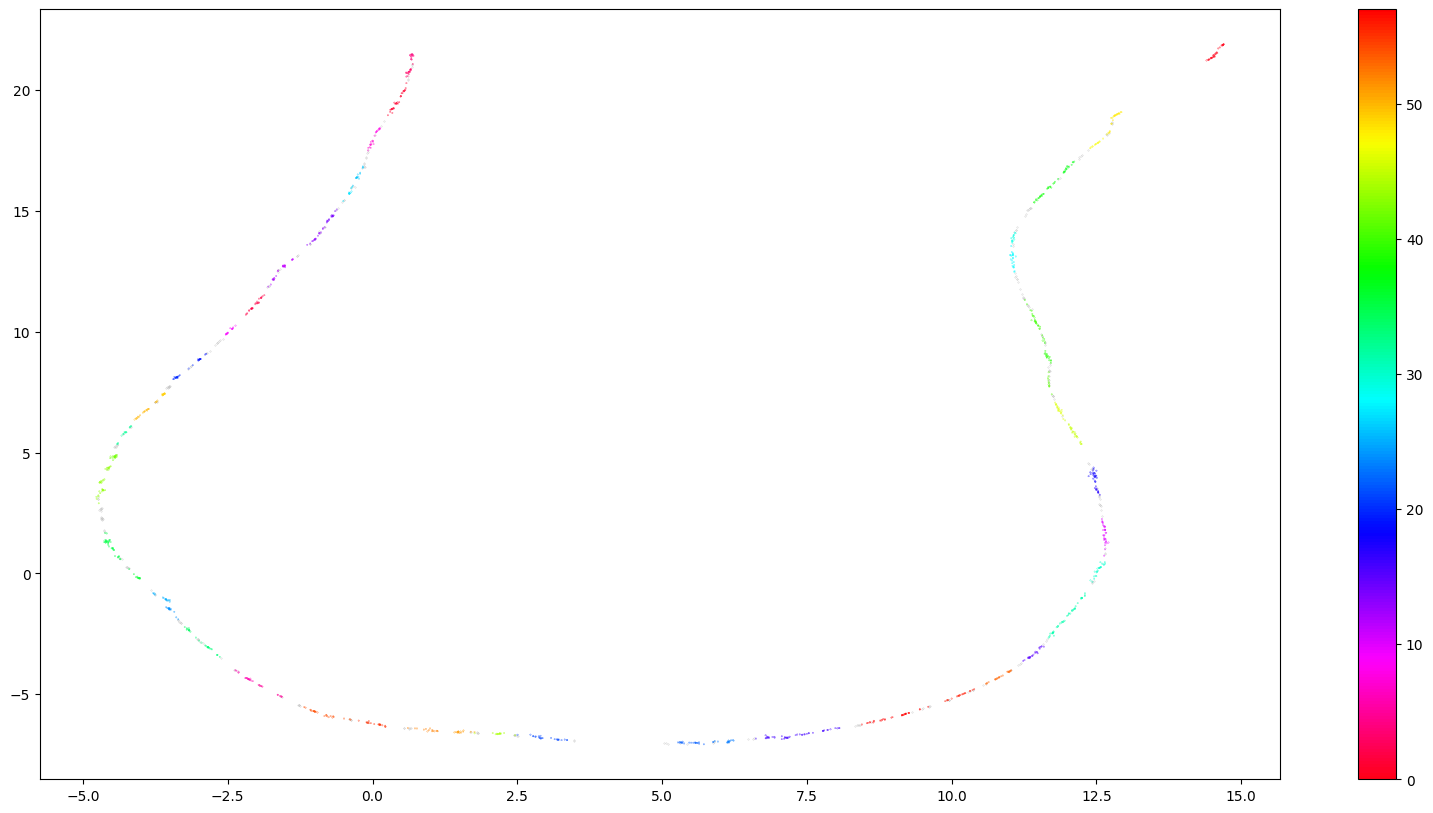

In [35]:
umap_data = UMAP(n_neighbors=20, n_components=2, metric='cosine').fit_transform(flat_embeddings)
viz = pd.DataFrame(umap_data, columns=['x', 'y'])
viz['labels'] = hdbscan.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = viz.loc[viz.labels == -1, :]
clustered = viz.loc[viz.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

V následující části jsou získána slova příslušející jednotlivým shlukům a názvy článků, které byly do daných shluků zařazeny. Toho je využito pro nalezení klíčových slov charakterizujících daný shluk (tedy dané téma) a vyhledávání témat a článků se stejným tématem podle názvu.

In [36]:
text_df = pd.DataFrame(tokenized_texts['text'], columns=['text'])
title_df = pd.DataFrame(tokenized_texts['title'], columns=['title'])
text_df['topic'] = hdbscan.labels_
text_df['ID'] = range(len(text_df))
title_df['topic'] = hdbscan.labels_
title_df['ID'] = range(len(title_df))
text_per_topic = text_df.groupby(['topic'], as_index=False).agg({'text' : ' '.join})
titles_per_topic = title_df.groupby(['topic'], as_index=False).agg({'title' : list})

In [37]:
text_per_topic.head(10)

topic                                               text
0     -1  [CLS] the pure spinor formulation of the ten -...
1      0  [CLS] we discuss the results from the combined...
2      1  [CLS] in this article we discuss a relation be...
3      2  [CLS] in the article [ petojev ##ic ] a petoje...
4      3  [CLS] this is a supplement to the paper arxiv ...
5      4  [CLS] no abstract given compare ##s pairs of l...
6      5  [CLS] recently br ##uin ##ier and on ##o class...
7      6  [CLS] we review recent progress in applying th...
8      7  [CLS] in this paper we show how to compute the...
9      8  [CLS] recent observational and theoretical adv...

In [38]:
titles_per_topic.head(10)

topic                                              title
0     -1  [Fermionic superstring loop amplitudes in the ...
1      0  [The Spitzer c2d Survey of Large, Nearby, Inst...
2      1  [Iterated integral and the loop product, Confo...
3      2  [A Note About the {Ki(z)} Functions, Quantum D...
4      3  [Origin of adaptive mutants: a quantum measure...
5      4  [Pairwise comparisons of typological profiles ...
6      5  [Distribution of integral Fourier Coefficients...
7      6  [Viscosity, Black Holes, and Quantum Field The...
8      7  [From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\...
9      8  [Masers and star formation, QED x QCD Resummat...

Class-based TF-IDF:

In [39]:
def c_tf_idf(data, m, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(data)
    t = vectorizer.transform(data).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, vectorizer

tf_idf, vectorizer = c_tf_idf(text_per_topic.text.values, len(tokenized_texts))

Extrahování nejdůležitějších slov pro téma a seřazení témat podle velikosti:

In [40]:
def extract_top_n_words(tf_idf, vectorizer, docs_per_topic, n=10):
    words = vectorizer.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic']).text.count().reset_index().rename({'topic': 'topic', 'text': 'size'}, axis='columns')
                     .sort_values('size', ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words(tf_idf, vectorizer, text_per_topic)
topic_sizes = extract_topic_sizes(text_df)
topic_sizes.head(10)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


topic  size
0      -1   303
32     31    48
17     16    47
36     35    37
44     43    36
2       1    34
11     10    33
58     57    33
1       0    32
41     40    30

Nejdůležitější slova tří největších témat (-1 jsou outlieři):

In [41]:
top_n_words[31]

[('morita', 0.005894724871643491),
 ('one', 0.005162542629989361),
 ('pion', 0.0050903071504679355),
 ('its', 0.004911017264439033),
 ('brane', 0.00483604328179845),
 ('pair', 0.00476148823460622),
 ('critical', 0.004609184133610693),
 ('bodies', 0.004538391004071045),
 ('pdes', 0.004421043653732619),
 ('between', 0.004319495432019199)]

In [42]:
top_n_words[16]

[('algorithm', 0.007047185549584669),
 ('mu', 0.006222704546431774),
 ('field', 0.006194781202462743),
 ('theories', 0.005232409784668455),
 ('theory', 0.005027822991677506),
 ('sbottom', 0.004959810847527131),
 ('one', 0.004846756631064169),
 ('effects', 0.004831828710850575),
 ('photon', 0.00481818822313773),
 ('homomorphism', 0.004801270363358475)]

In [43]:
top_n_words[35]

[('entropy', 0.011001637255731792),
 ('thermal', 0.009877859812816308),
 ('states', 0.007514000463675257),
 ('spreading', 0.007074814713184615),
 ('pure', 0.0069057625822157),
 ('trail', 0.006808454162526054),
 ('quantum', 0.006627638601326011),
 ('renormalization', 0.006369289688700206),
 ('property', 0.006318765896458443),
 ('temperature', 0.006277929675466668)]

Základ vyhledávání podobných článků (respektive abstraktů). První funkce slouží pro nalezení tématu článku, parametrem je název článku. Druhá funkce nachází podobné články, parametry jsou název článku a počet podobných článků. Níže je příklad využití těchto funkcí.

In [44]:
topics_by_titles = titles_per_topic.explode('title')

def get_topic_by_title(title):
    topic_num = topics_by_titles[topics_by_titles['title'] == title]['topic'].values[0]
    topic = top_n_words[topic_num]
    return topic

def get_n_similar_articles(title, n):
    topic_num = topics_by_titles[topics_by_titles['title'] == title]['topic'].values[0]
    all_titles = titles_per_topic[titles_per_topic['topic'] == topic_num]['title'].values[0]
    titles = []
    for i in range(min(len(all_titles), n)):
        titles.append(all_titles[i])
    return titles

In [45]:
title = data.loc[0]['title']
print(title)
get_topic_by_title(title)

Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies


[('planets', 0.006678977641771013),
 ('rdc', 0.0063452912291081165),
 ('state', 0.006218919155012802),
 ('resummation', 0.00616814047657727),
 ('qubits', 0.005848247961116753),
 ('momentum', 0.005384426509399518),
 ('one', 0.005337837699409877),
 ('seen', 0.005201040467005571),
 ('entangled', 0.005158473738753884),
 ('am', 0.005065523389171163)]

In [46]:
get_n_similar_articles(title, 10)

['Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
 'A general approach to statistical modeling of physical laws:\n  nonparametric regression',
 'A Comparison between Anomalous 6-cm H$_2$CO Absorption and CO(1-0)\n  Emission in the L1204/S140',
 'Isospin breaking in the yield of heavy meson pairs in e+e- annihilation\n  near threshold',
 'Reality of linear and angular momentum expectation values in bound\n  states',
 'Entanglement increase from local interactions with\n  not-completely-positive maps',
 'Vortex Dynamics at the Initial Stage of Resistive Transition in\n  Superconductors with Fractal Cluster Structure',
 'Effective conservation of energy and momentum algorithm using switching\n  potentials suitable for molecular dynamics simulation of thermodynamical\n  systems',
 'Optical spectrum of the post-AGB star HD56126 in the region 4010-8790 AA',
 'On second order shape optimization methods for electrical impedance\n  tomography']

Evaluace. Kvalita extrahovaných témat je vyhodnocena pomocí metriky topic coherence.

In [48]:
def get_coherence_score_bert(topics, texts):
    dictionary = corpora.Dictionary(texts)
    topic_words = []
    for topic in topics:
        topic_w = [words for words, _ in topics[topic]]
        topic_words.append(topic_w)
    coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

In [49]:
tokenized = tokenized_texts['text']
tokenized = tokenized.str.split(' ')

coherence = get_coherence_score_bert(top_n_words, tokenized)
print(f'BERT: coherence score {coherence}.')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c085c94-9ee8-4868-b095-5113f7478b44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>